<a href="https://colab.research.google.com/github/KalyanMohanty/Tensorflow_series/blob/master/Text_classification_with_preprocessed_text_Movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
!pip install -q tf -nightly


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -n


In [3]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', split = (tfds.Split.TRAIN, tfds.Split.TEST), as_supervised = True, with_info = True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWPRV92/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWPRV92/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWPRV92/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


#Try the encoder
The dataset info includes the text encoder (a tfds.features.text.SubwordTextEncoder).

In [5]:
encoder = info.features['text'].encoder
print('vocabulary size: {}'.format(encoder.vocab_size))

vocabulary size: 8185


In [19]:
sample_string = 'hello world'
encoded_string = encoder.encode(sample_string)
print('Encoded string is:{}'.format(encoded_string))

Encoded string is:[3618, 222, 562]


In [17]:
original_string = encoder.decode(encoded_string)
print('The original string:'"{}"'.format(original_string))
assert original_string == sample_string

The original string:"hello world"


The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.

In [20]:
for i in encoded_string:
  print('{}----->{}'.format(i, encoder.decode([i])))

3618----->hell
222----->o 
562----->world


# Exploring the data
Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review.

The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary.

Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [23]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:20].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681]
Label: 0


In [24]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

# Prepare the data for training

You will want to create batches of training data for your model. The reviews are all different lengths, so use padded_batch to zero pad the sequences while batching:

In [0]:
BUFFER_SIZE = 1000
train_batches = (train_data.shuffle(BUFFER_SIZE).padded_batch(32, padded_shapes = ([None],[])))
test_batches = (test_data.padded_batch(32, padded_shapes= ([None],[])))

* Note: As of TensorFlow 2.2 the padded_shapes argument is no longer required. The default behavior is to pad all axes to the longest in the batch.

Each batch will have a shape of (batch_size, sequence_length) because the padding is dynamic each batch will have a different length

In [30]:
for example_batch, label_batch in train_batches.take(2):
  print('Batch shape:', example_batch.shape)
  print('Label shape:', label_batch.shape)

Batch shape: (32, 820)
Label shape: (32,)
Batch shape: (32, 1043)
Label shape: (32,)


# Building the model
* the input data consists of an array of word-indices. The labels to predict are either 0 or 1. Let's build a "Continuous bag of words" style model for this problem.
* Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output. To fix this, see the masking and padding guide.

In [31]:
model = keras.Sequential([
                          keras.layers.Embedding(encoder.vocab_size, 16),
                          keras.layers.GlobalAveragePooling1D(),
                          keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

* The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the word embedding tutorial.
* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level. For numerical stability, use the linear activation function that represents the logits

In [0]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the binary_crossentropy loss function.

This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, binary_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.

Now, configure the model to use an optimizer and a loss function:

# Train the model

In [35]:
history = model.fit(train_batches,epochs = 10,
                    validation_data = test_batches,
                    validation_steps = 30)

Epoch 1/10
782/782 [==============================] - 10s 12ms/step - loss: 0.6823 - accuracy: 0.5003 - val_loss: 0.6657 - val_accuracy: 0.5042
Epoch 2/10
782/782 [==============================] - 9s 12ms/step - loss: 0.6235 - accuracy: 0.5506 - val_loss: 0.5983 - val_accuracy: 0.5875
Epoch 3/10
782/782 [==============================] - 9s 11ms/step - loss: 0.5461 - accuracy: 0.6571 - val_loss: 0.5366 - val_accuracy: 0.7031
Epoch 4/10
782/782 [==============================] - 9s 12ms/step - loss: 0.4780 - accuracy: 0.7476 - val_loss: 0.4867 - val_accuracy: 0.7792
Epoch 5/10
782/782 [==============================] - 9s 12ms/step - loss: 0.4255 - accuracy: 0.7988 - val_loss: 0.4487 - val_accuracy: 0.7875
Epoch 6/10
782/782 [==============================] - 9s 12ms/step - loss: 0.3851 - accuracy: 0.8308 - val_loss: 0.4203 - val_accuracy: 0.8042
Epoch 7/10
782/782 [==============================] - 9s 12ms/step - loss: 0.3524 - accuracy: 0.8504 - val_loss: 0.3993 - val_accuracy: 0.841

# Evaluate the model

In [37]:
loss,accuracy = model.evaluate(test_batches)
print('Loss:', loss)
print('Accuracy:', accuracy)


782/782 [==============================] - 6s 7ms/step - loss: 0.3337 - accuracy: 0.8539
Loss: 0.33373570442199707
Accuracy: 0.8539199829101562


# Graph over time

In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

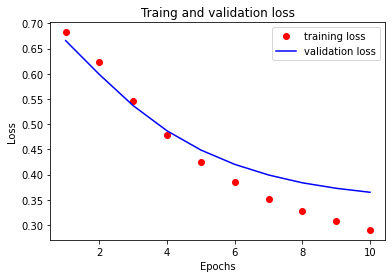

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'ro', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')

plt.title('Traing and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

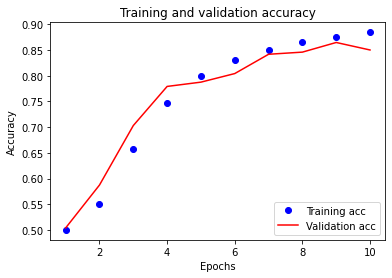

In [44]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.